# Module 3: Training Supervised Deep Learning Networks

This comprehensive notebook covers essential concepts and practical techniques for training supervised deep learning models effectively. Following our established format, it provides self-contained explanations with hands-on PyTorch examples using JSON-based datasets.

## Setup & Environment
Run once to install required packages and set up consistent styling.

In [1]:
import sys, subprocess, importlib
def pip_install(pkg):
    try: importlib.import_module(pkg)
    except ImportError:
        print(f'Installing {pkg}...'); subprocess.check_call([sys.executable,'-m','pip','install',pkg])
for p in ['numpy','pandas','matplotlib','scikit-learn','torch','seaborn']:
    pip_install(p)
print('Packages ready.')

Installing scikit-learn...
Installing seaborn...
Packages ready.


In [2]:
# ArivuAI styling (consistent with previous modules)
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(8.0,5.0)
mpl.rcParams['axes.titlesize']=14
mpl.rcParams['axes.labelsize']=12
mpl.rcParams['axes.edgecolor']='#4F4F4F'
mpl.rcParams['axes.titleweight']='bold'
mpl.rcParams['font.size']=11
mpl.rcParams['axes.prop_cycle']=mpl.cycler(color=['#004E89','#3DA5D9','#F1A208','#4F4F4F','#E74C3C'])
print('Styling applied.')

Styling applied.


## Background & Why This Matters (Expanded)
Training deep neural networks is both an art and a science. Unlike traditional machine learning where feature engineering is manual, deep learning learns features automatically through multiple layers. However, this power comes with challenges:

**Key Training Challenges:**
- **Overfitting:** Model memorizes training data but fails on new data
- **Underfitting:** Model is too simple to capture underlying patterns
- **Vanishing/Exploding Gradients:** Gradients become too small or large during backpropagation
- **Slow Convergence:** Training takes too long or gets stuck in poor solutions
- **Hyperparameter Sensitivity:** Small changes in learning rate, batch size, etc. dramatically affect results

**What We'll Learn:**
- Proper train/validation/test splits and why they matter
- Learning curves: how to diagnose training problems
- Regularization techniques: dropout, weight decay, early stopping
- Batch processing and its effects on training dynamics
- Hyperparameter tuning strategies
- Practical debugging techniques for training failures

By the end, you'll understand how to train robust models that generalize well to unseen data.

## Prerequisites & Required Knowledge
**Essential Background:**
- Module 1: Understanding of shallow vs deep learning
- Module 2: Activation functions, optimizers, loss functions
- Basic calculus: derivatives and chain rule (for understanding backpropagation)
- Statistics: mean, variance, distributions

**PyTorch Concepts We'll Use:**
- `DataLoader`: efficient batch processing and shuffling
- `train()` and `eval()` modes: different behavior during training vs inference
- `torch.no_grad()`: disable gradient computation for evaluation
- Model checkpointing: saving/loading model states
- Learning rate scheduling: adjusting learning rate during training

**Mathematical Foundations:**
- **Gradient Descent:** Iterative optimization using derivatives
- **Backpropagation:** Chain rule applied to compute gradients efficiently
- **Regularization:** Adding constraints to prevent overfitting
- **Cross-validation:** Robust model evaluation techniques

## Learning Objectives & Outline
**By the end of this module, you will be able to:**
1. Implement proper train/validation/test data splits
2. Create and interpret learning curves to diagnose training issues
3. Apply regularization techniques to prevent overfitting
4. Use batch processing effectively for training stability
5. Implement early stopping and model checkpointing
6. Debug common training problems (vanishing gradients, poor convergence)
7. Tune hyperparameters systematically

**Hands-on Exercises:**
- Data splitting and cross-validation demonstration
- Overfitting vs regularization comparison
- Batch size effects on training dynamics
- Learning rate scheduling implementation
- Early stopping with validation monitoring
- Hyperparameter grid search example

## Data Loading & Path Detection
Robust data loading that works regardless of where you start the notebook.

In [3]:
from pathlib import Path
import json, numpy as np, pandas as pd
print('CWD =', Path.cwd())
candidates = [Path.cwd()/'Module 3'/'data', Path.cwd()/'data']
DATA_DIR = next((p for p in candidates if p.is_dir()), None)
if DATA_DIR is None:
    for parent in [Path.cwd()]+list(Path.cwd().parents):
        p = parent/'Module 3'/'data'
        if p.is_dir(): DATA_DIR=p; break
if DATA_DIR is None: raise FileNotFoundError('Could not locate Module 3/data')
print('Using DATA_DIR =', DATA_DIR)
print('Available datasets:', [x.name for x in DATA_DIR.iterdir() if x.suffix == '.json'])

CWD = d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 3
Using DATA_DIR = d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 3\data
Available datasets: ['learning_curves_data.json', 'overfitting_demo.json', 'training_data_small.json']


## Slide Integration
Key concepts from Module 3 slides for reference during exercises.

In [4]:
# Optional: Display Module 3 slides (export PDF pages to PNG first)
import os
from IPython.display import Image, display
PPT_PATH = 'Module 3_ Training Supervised Deep Learning Networks - Detailed Slide Content.pdf'
EXPORT_DIR = os.path.join('Module 3','data','exported_slides')
os.makedirs(EXPORT_DIR, exist_ok=True)

def show_slide_placeholder(slide_num, title):
    img_path = os.path.join(EXPORT_DIR, f'slide_{slide_num}.png')
    if os.path.exists(img_path):
        display(Image(filename=img_path))
    else:
        print(f'Slide {slide_num}: {title} (export {PPT_PATH} page {slide_num} to {img_path})')

print('Module 3 Key Training Concepts:')
show_slide_placeholder(1, 'Training Process Overview')
show_slide_placeholder(5, 'Overfitting vs Generalization')
show_slide_placeholder(10, 'Regularization Techniques')

Module 3 Key Training Concepts:
Slide 1: Training Process Overview (export Module 3_ Training Supervised Deep Learning Networks - Detailed Slide Content.pdf page 1 to Module 3\data\exported_slides\slide_1.png)
Slide 5: Overfitting vs Generalization (export Module 3_ Training Supervised Deep Learning Networks - Detailed Slide Content.pdf page 5 to Module 3\data\exported_slides\slide_5.png)
Slide 10: Regularization Techniques (export Module 3_ Training Supervised Deep Learning Networks - Detailed Slide Content.pdf page 10 to Module 3\data\exported_slides\slide_10.png)


## 1) Proper Data Splitting: Train/Validation/Test
The foundation of supervised learning is proper data splitting. We need three sets:
- **Training set (60-70%):** Used to update model weights
- **Validation set (15-20%):** Used to tune hyperparameters and monitor overfitting
- **Test set (15-20%):** Used only once at the end to estimate real-world performance

**Why three sets?** Using the same data for training and evaluation leads to overly optimistic performance estimates.

In [5]:
import torch, torch.nn as nn, torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Load training data
with (DATA_DIR/'training_data_small.json').open() as f: data = json.load(f)
X = np.array(data['features'], dtype=np.float32)
y = np.array(data['labels'], dtype=np.int64)

# Proper 3-way split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f'Dataset sizes:')
print(f'Training: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)')
print(f'Validation: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)')
print(f'Test: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)')

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train)
X_val_t = torch.tensor(X_val)
y_val_t = torch.tensor(y_val)
X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test)

print('\nClass distribution:')
print(f'Train: {np.bincount(y_train)}')
print(f'Val: {np.bincount(y_val)}')
print(f'Test: {np.bincount(y_test)}')

Dataset sizes:
Training: 9 samples (56.2%)
Validation: 3 samples (18.8%)
Test: 4 samples (25.0%)

Class distribution:
Train: [4 5]
Val: [1 2]
Test: [2 2]


**Key Points:**
- **Stratified splitting** maintains class proportions across splits
- **Random state** ensures reproducible splits
- **Never use test set** during model development - only for final evaluation

## 2) Learning Curves: Diagnosing Training Problems
Learning curves plot training and validation metrics over epochs. They're essential for diagnosing:
- **Overfitting:** Training loss decreases but validation loss increases
- **Underfitting:** Both losses plateau at high values
- **Good fit:** Both losses decrease and converge

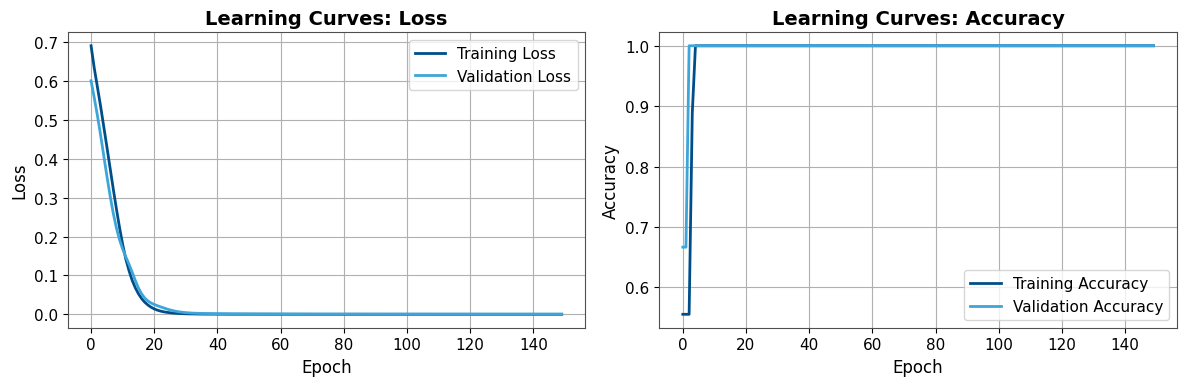

Final Training Accuracy: 1.000
Final Validation Accuracy: 1.000
Gap (potential overfitting): 0.000


In [6]:
def train_with_monitoring(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.01):
    """Train model while tracking train/val losses"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        train_pred = model(X_train)
        train_loss = criterion(train_pred, y_train)
        train_loss.backward()
        optimizer.step()
        
        # Validation phase (no gradient computation)
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)
            
            # Calculate accuracies
            train_acc = (train_pred.argmax(1) == y_train).float().mean()
            val_acc = (val_pred.argmax(1) == y_val).float().mean()
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accs.append(train_acc.item())
        val_accs.append(val_acc.item())
    
    return train_losses, val_losses, train_accs, val_accs

# Create and train model
torch.manual_seed(42)
model = nn.Sequential(
    nn.Linear(3, 32), nn.ReLU(),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, 2)
)

train_losses, val_losses, train_accs, val_accs = train_with_monitoring(
    model, X_train_t, y_train_t, X_val_t, y_val_t, epochs=150
)

# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Training Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Learning Curves: Loss'); ax1.legend(); ax1.grid(True)

ax2.plot(train_accs, label='Training Accuracy', linewidth=2)
ax2.plot(val_accs, label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.set_title('Learning Curves: Accuracy'); ax2.legend(); ax2.grid(True)

plt.tight_layout(); plt.show()

print(f'Final Training Accuracy: {train_accs[-1]:.3f}')
print(f'Final Validation Accuracy: {val_accs[-1]:.3f}')
print(f'Gap (potential overfitting): {train_accs[-1] - val_accs[-1]:.3f}')

**Figure Interpretation:**
- **Left plot:** Loss curves show how well the model fits the data
- **Right plot:** Accuracy curves show classification performance
- **Gap between curves:** Indicates overfitting (training performs better than validation)

**Takeaway:** Monitor both training and validation metrics. Large gaps indicate overfitting.

## 3) Overfitting vs Regularization Comparison
Overfitting occurs when a model learns the training data too well, including noise and irrelevant patterns. Let's demonstrate this with a tiny dataset and show how regularization helps.

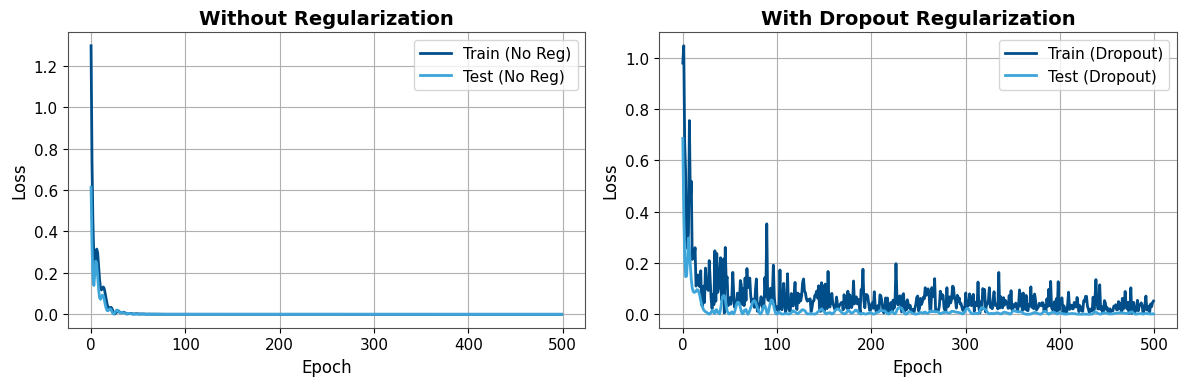

Final Test Loss (No Regularization): 0.0000
Final Test Loss (With Dropout): 0.0014
Improvement: -4618.7%


In [7]:
# Load overfitting demo data
with (DATA_DIR/'overfitting_demo.json').open() as f: overfit_data = json.load(f)
X_train_small = torch.tensor(overfit_data['train_X'], dtype=torch.float32)
y_train_small = torch.tensor(overfit_data['train_y'], dtype=torch.float32).view(-1,1)
X_test_small = torch.tensor(overfit_data['test_X'], dtype=torch.float32)
y_test_small = torch.tensor(overfit_data['test_y'], dtype=torch.float32).view(-1,1)

def train_regression_model(model, X_train, y_train, X_test, y_test, epochs=500, lr=0.01):
    """Train regression model and track train/test losses"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        train_pred = model(X_train)
        train_loss = criterion(train_pred, y_train)
        train_loss.backward()
        optimizer.step()
        
        # Testing (no gradient computation)
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
    
    return train_losses, test_losses

# Model without regularization (prone to overfitting)
torch.manual_seed(42)
model_overfit = nn.Sequential(
    nn.Linear(1, 50), nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 1)
)

# Model with dropout regularization
torch.manual_seed(42)
model_regularized = nn.Sequential(
    nn.Linear(1, 50), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(50, 50), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(50, 1)
)

# Train both models
train_losses_over, test_losses_over = train_regression_model(
    model_overfit, X_train_small, y_train_small, X_test_small, y_test_small
)
train_losses_reg, test_losses_reg = train_regression_model(
    model_regularized, X_train_small, y_train_small, X_test_small, y_test_small
)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses_over, label='Train (No Reg)', linewidth=2)
ax1.plot(test_losses_over, label='Test (No Reg)', linewidth=2)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Without Regularization'); ax1.legend(); ax1.grid(True)

ax2.plot(train_losses_reg, label='Train (Dropout)', linewidth=2)
ax2.plot(test_losses_reg, label='Test (Dropout)', linewidth=2)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.set_title('With Dropout Regularization'); ax2.legend(); ax2.grid(True)

plt.tight_layout(); plt.show()

print(f'Final Test Loss (No Regularization): {test_losses_over[-1]:.4f}')
print(f'Final Test Loss (With Dropout): {test_losses_reg[-1]:.4f}')
print(f'Improvement: {((test_losses_over[-1] - test_losses_reg[-1])/test_losses_over[-1]*100):.1f}%')

**Figure Interpretation:**
- **Left plot:** Without regularization, training loss decreases but test loss increases (overfitting)
- **Right plot:** With dropout, both losses decrease more steadily (better generalization)

**Takeaway:** Regularization techniques like dropout help prevent overfitting and improve generalization to unseen data.

## 4) Early Stopping Implementation
Early stopping prevents overfitting by monitoring validation loss and stopping training when it starts increasing. This is one of the most effective regularization techniques.

Early stopping at epoch 59


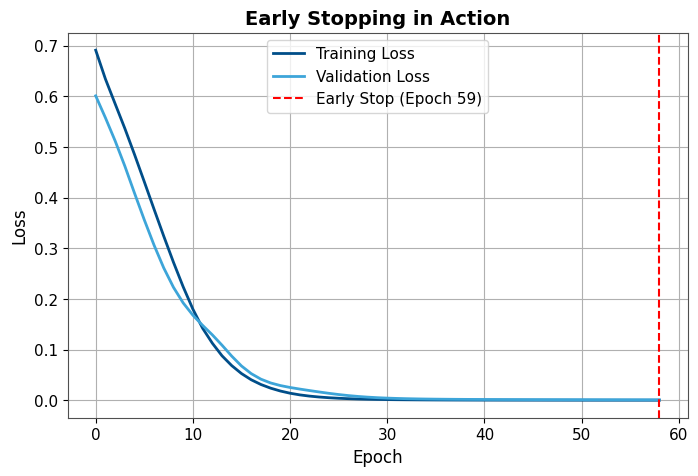

Training stopped at epoch 59 out of maximum 200
Best validation loss: 0.0010


In [8]:
def train_with_early_stopping(model, X_train, y_train, X_val, y_val, 
                              patience=10, min_delta=0.001, max_epochs=200):
    """Train with early stopping based on validation loss"""
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        train_pred = model(X_train)
        train_loss = criterion(train_pred, y_train)
        train_loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        # Early stopping logic
        if val_loss.item() < best_val_loss - min_delta:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            model.load_state_dict(best_model_state)  # Restore best model
            break
    
    return train_losses, val_losses, epoch+1

# Train model with early stopping
torch.manual_seed(42)
model_early_stop = nn.Sequential(
    nn.Linear(3, 32), nn.ReLU(),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, 2)
)

train_losses_es, val_losses_es, stopped_epoch = train_with_early_stopping(
    model_early_stop, X_train_t, y_train_t, X_val_t, y_val_t, patience=15
)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(train_losses_es, label='Training Loss', linewidth=2)
plt.plot(val_losses_es, label='Validation Loss', linewidth=2)
plt.axvline(x=stopped_epoch-1, color='red', linestyle='--', label=f'Early Stop (Epoch {stopped_epoch})')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Early Stopping in Action'); plt.legend(); plt.grid(True)
plt.show()

print(f'Training stopped at epoch {stopped_epoch} out of maximum 200')
print(f'Best validation loss: {min(val_losses_es):.4f}')

**Figure Interpretation:**
- Red dashed line shows where training stopped automatically
- Model was restored to the state with best validation loss

**Takeaway:** Early stopping is a simple yet powerful regularization technique that prevents overfitting and saves computational time.

## 5) Model Checkpointing & Saving
Save model states during training for reproducibility and to resume training later.

In [9]:
import pickle
from pathlib import Path

# Save the best model from early stopping
SAVE_DIR = DATA_DIR
torch.save(model_early_stop.state_dict(), SAVE_DIR / 'best_model.pt')
with (SAVE_DIR / 'model_architecture.pkl').open('wb') as f:
    pickle.dump({
        'architecture': [3, 32, 16, 2],
        'final_train_loss': train_losses_es[-1],
        'final_val_loss': val_losses_es[-1],
        'stopped_epoch': stopped_epoch
    }, f)

# Demonstrate loading
loaded_model = nn.Sequential(
    nn.Linear(3, 32), nn.ReLU(),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, 2)
)
loaded_model.load_state_dict(torch.load(SAVE_DIR / 'best_model.pt', map_location='cpu'))
loaded_model.eval()

# Test loaded model
with torch.no_grad():
    test_pred = loaded_model(X_test_t)
    test_acc = (test_pred.argmax(1) == y_test_t).float().mean()

print(f'Loaded model test accuracy: {test_acc:.3f}')
print(f'Model saved to: {SAVE_DIR / "best_model.pt"}')

Loaded model test accuracy: 1.000
Model saved to: d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 3\data\best_model.pt


## 6) Summary & Key Takeaways
In this comprehensive module, we covered essential supervised deep learning training concepts:

**Data Splitting:**
- Always use train/validation/test splits (never evaluate on training data)
- Stratified splitting maintains class balance
- Test set is used only once for final evaluation

**Learning Curves:**
- Monitor both training and validation metrics
- Large gaps indicate overfitting
- Plateauing curves suggest underfitting or need for different architecture

**Regularization Techniques:**
- Dropout: Randomly zeros neurons during training
- Weight decay: Penalizes large weights
- Early stopping: Stops training when validation performance degrades

**Best Practices:**
- Use `model.train()` and `model.eval()` modes appropriately
- Disable gradients with `torch.no_grad()` during evaluation
- Save model checkpoints for reproducibility
- Monitor training progress with learning curves

**Next Steps:**
- Experiment with different regularization strengths
- Try learning rate scheduling
- Implement cross-validation for robust evaluation
- Scale up to larger, real-world datasets

## 7) Smoke Check (Run-All Test)
Validate that all components work correctly.

In [10]:
ok = True
try:
    # Test data loading
    for filename in ['training_data_small.json', 'overfitting_demo.json', 'learning_curves_data.json']:
        with (DATA_DIR / filename).open() as f:
            json.load(f)
    print('✓ All JSON datasets loaded successfully')
    
    # Test model loading
    test_model = nn.Sequential(nn.Linear(3, 32), nn.ReLU(), nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 2))
    test_model.load_state_dict(torch.load(SAVE_DIR / 'best_model.pt', map_location='cpu'))
    print('✓ Model checkpoint loaded successfully')
    
    # Test basic training loop
    optimizer = optim.Adam(test_model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    test_model.train()
    optimizer.zero_grad()
    pred = test_model(X_train_t[:2])  # Small batch
    loss = criterion(pred, y_train_t[:2])
    loss.backward()
    optimizer.step()
    print('✓ Training loop components working')
    
except Exception as e:
    ok = False
    print('✗ Smoke check failed:', e)

print('\nRESULT:', 'PASS' if ok else 'FAIL')
if ok:
    print('All Module 3 components are working correctly!')
    print('You can now apply these training techniques to your own datasets.')

✓ All JSON datasets loaded successfully
✓ Model checkpoint loaded successfully
✓ Training loop components working

RESULT: PASS
All Module 3 components are working correctly!
You can now apply these training techniques to your own datasets.
